In [42]:
import random
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
## [rRNA1, rRNA2, mRNA1, mRNA2, .., mRNA13]
name = [
    'MT-RNR1', 'MT-RNR2', 
    'MT-ND1', 'MT-ND2', 
    'MT-CO1', 'MT-CO2', 
    'MT-ATP8', 'MT-ATP6', 
    'MT-CO3', 'MT-ND3', 
    'MT-ND4L', 'MT-ND4', 
    'MT-ND5', 'MT-ND6', 
    'MT-CYB', 
]

## Reactions
# Productions
p1 = np.zeros(15)
p1[13] = 1 # ND6
p2 = np.ones(15)
p2[13] = 0
p3 = np.zeros(15)
p3[0] = 1
p3[1] = 1
v = [p1, p2, p3]

# Degradation
d = []
for i in range(15):
    z = np.zeros(15)
    z[i] = -1
    d.append(z)
v += d

In [4]:
'''
## Coefficient of Rates (per min)
# 20/min, 100 mtDNA
p_rate = 20 * 100
# half life 1.5 hours, rRNA
d_rate_coef_1 = np.log(2) / 5760
# half life 4 days, mRNA
d_rate_coef_2 = np.log(2) / 90

c = [p_rate, p_rate * 9/10, p_rate * 1/10]
for i in range(2):
    c.append(d_rate_coef_1)
for i in range(13):
    c.append(d_rate_coef_2)

print(c)
'''

'\n## Coefficient of Rates (per min)\n# 20/min, 100 mtDNA\np_rate = 20 * 100\n# half life 1.5 hours, rRNA\nd_rate_coef_1 = np.log(2) / 5760\n# half life 4 days, mRNA\nd_rate_coef_2 = np.log(2) / 90\n\nc = [p_rate, p_rate * 9/10, p_rate * 1/10]\nfor i in range(2):\n    c.append(d_rate_coef_1)\nfor i in range(13):\n    c.append(d_rate_coef_2)\n\nprint(c)\n'

numbers in the array : (transcription) / cell
c[0:2] are the production rates : cell / min
c[3:18] are the exponential decay constants : / min 

In [49]:
## Assuming the rates based on the real data
ref = np.array([
    0.00711734, 0.02502242, 0.00238953, 0.00118729, 0.0050315 ,
    0.00776707, 0.00454479, 0.00064914, 0.00606665, 0.00205203,
    0.00331425, 0.00110065, 0.00152889, 0.0003771 , 0.00518692
])
coef = 1 / ref
for i in range(2, 15):
    if i == 13:
        continue
    coef[i] = coef[i] * 0.9
coef /= 2 / np.average(np.log(2) / coef[2:15] / 60)
c = [20 * 100, 18 * 100, 2 * 100] + list(coef)

In [50]:
# Half life in hours
for i in range(15):
    print('%s & %6f & %6f \\\\' % (name[i], coef[i], np.log(2) / coef[i] / 60))

MT-RNR1 & 0.002855 & 4.046488 \\
MT-RNR2 & 0.000812 & 14.226231 \\
MT-ND1 & 0.007653 & 1.509491 \\
MT-ND2 & 0.015403 & 0.750023 \\
MT-CO1 & 0.003635 & 3.178451 \\
MT-CO2 & 0.002355 & 4.906539 \\
MT-ATP8 & 0.004024 & 2.870991 \\
MT-ATP6 & 0.028172 & 0.410068 \\
MT-CO3 & 0.003014 & 3.832366 \\
MT-ND3 & 0.008912 & 1.296289 \\
MT-ND4L & 0.005518 & 2.093646 \\
MT-ND4 & 0.016615 & 0.695292 \\
MT-ND5 & 0.011961 & 0.965816 \\
MT-ND6 & 0.053884 & 0.214396 \\
MT-CYB & 0.003526 & 3.276631 \\


In [70]:
def TauLeaping(t_ini, x_ini, timeLimit, tau):
    global c, v
    
    # Tau-Leaping with L Steps
    t = t_ini
    t_list = np.arange(t, t + timeLimit, tau)
    
    a = np.zeros(18)
    result = []
    x = x_ini
    for i in range(len(t_list)): 
        # Propensity Function
        for j in range(3):
            a[j] = c[j]
        for j in range(3, 18):
            a[j] = c[j] * x[j - 3]
        for j in range(18):
            if a[j] < 0: 
                a[j] = 0
        
        # Number of reactions during each step
        d = np.array([
            np.random.poisson(a[k] * tau, 1)[0] for k in range(18)
        ])
        
        x = x + np.dot(d, v)
        result.append(x)
    
    return(t_list, result)

In [7]:
def TauLeaping2(t_ini, x_ini, stepNum, tau):
    global c, v
    
    # Tau-Leaping with L Steps
    t = t_ini
    t_list = np.arange(t, t + stepNum * tau, tau * 60)
    
    a = np.zeros(17)
    result = []
    x = x_ini
    for i in range(stepNum): 
        # Propensity Function
        for j in range(2):
            a[j] = c[j]
        for j in range(2, 17):
            a[j] = c[j] * x[j - 2]
        for j in range(17):
            if a[j] < 0: 
                a[j] = 0
        
        # Number of reactions during each step
        d = np.array([
            np.random.poisson(a[k] * tau, 1)[0] for k in range(17)
        ])
        
        x = x + np.dot(d, v)
        if i % 60 == 0:
            result.append(x)
    
    return(t_list, result)

In [71]:
iter = 50
t_limit = 60000
t_current = 0
t_step = 3000
x_current = np.zeros((iter, 15))
diff = np.array([])
key = 0

st = time.time()
while t_current < t_limit:
    results_temp = []
    for i in range(iter):
        t_list, result = TauLeaping(t_ini = t_current, x_ini = x_current[i], timeLimit = t_step, tau = 1)
        x_current[i] = result[t_step - 1]
        results_temp.append(result)
    results_temp = np.array(results_temp)
    
    if t_current == 0:
        results = results_temp
    else: 
        results = np.concatenate((results, results_temp), axis = 1)
    t_current += t_step
    print(t_current, time.time() - st)
    
    key1 = np.average(np.transpose(results, [2, 1, 0])[1][t_current - 1])
    diff = np.append(diff, key1 - key)
    # print(np.average(diff[-5:]), diff[-5:])
    if np.abs(np.average(diff[-5:])) > 100:
        key = key1
    else:
        break
results = np.array(results)

3000 9.25217080116272
3496005.84 [3496005.84]
6000 17.067479610443115
2275004.2 [3496005.84 1054002.56]
9000 24.855817794799805
1622555.0199999998 [3496005.84 1054002.56  317656.66]
12000 32.37353539466858
1240877.54 [3496005.84 1054002.56  317656.66   95845.1 ]
15000 39.803293228149414
998448.2119999999 [3496005.84 1054002.56  317656.66   95845.1    28730.9 ]
18000 47.23219585418701
301044.34800000006 [1054002.56  317656.66   95845.1    28730.9     8986.52]
21000 55.7898063659668
90811.43599999994 [317656.66  95845.1   28730.9    8986.52   2838.  ]
24000 64.16053795814514
27227.444000000134 [95845.1  28730.9   8986.52  2838.    -263.3 ]
27000 71.95737433433533
8029.43200000003 [28730.9   8986.52  2838.    -263.3   -144.96]
30000 79.65684628486633
2426.8080000000073 [8986.52 2838.   -263.3  -144.96  717.78]
33000 87.38283610343933
580.6240000000223 [2838.   -263.3  -144.96  717.78 -244.4 ]
36000 94.89530420303345
79.89599999990314 [-263.3  -144.96  717.78 -244.4   334.36]


In [38]:
results.shape

(50, 39000, 15)

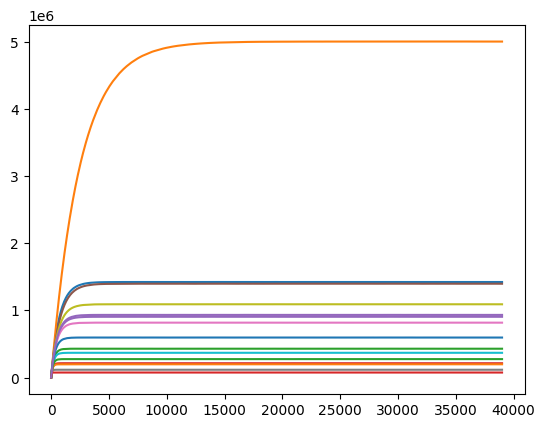

In [39]:
t_list = np.linspace(0, t_current - 1, t_current)
for i in range(15):
    plt.plot(t_list, [np.average(data) for data in np.transpose(results, (2, 1, 0))[i]])
plt.show()

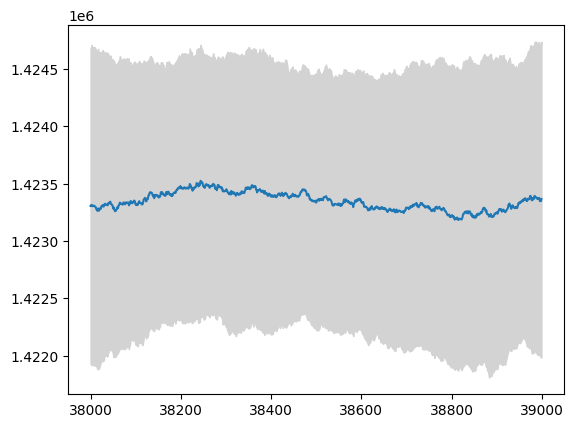

In [40]:
i = 0
p = 1
plt.plot(t_list[t_current - 1000: t_current], [np.average(data) for data in np.transpose(results, (2, 1, 0))[i]][t_current - 1000: t_current])
plt.fill_between(
    t_list[t_current - 1000: t_current], 
    [np.average(data) + p * np.std(data) for data in np.transpose(results, (2, 1, 0))[i]][t_current - 1000: t_current], 
    [np.average(data) - p * np.std(data) for data in np.transpose(results, (2, 1, 0))[i]][t_current - 1000: t_current], 
    color = 'lightgray'
)
plt.show()

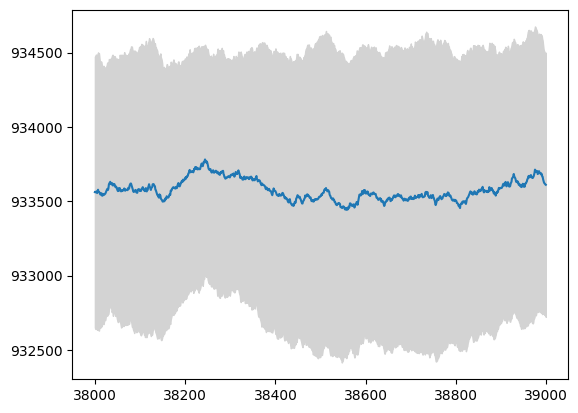

In [41]:
i = 14
p = 1
plt.plot(t_list[t_current - 1000: t_current], [np.average(data) for data in np.transpose(results, (2, 1, 0))[i]][t_current - 1000: t_current])
plt.fill_between(
    t_list[t_current - 1000: t_current], 
    [np.average(data) + p * np.std(data) for data in np.transpose(results, (2, 1, 0))[i]][t_current - 1000: t_current], 
    [np.average(data) - p * np.std(data) for data in np.transpose(results, (2, 1, 0))[i]][t_current - 1000: t_current], 
    color = 'lightgray'
)
plt.show()

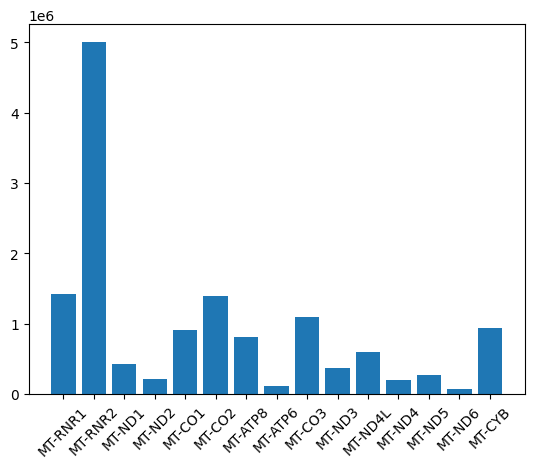

In [42]:
data = [np.average(dataCell) for dataCell in np.transpose(results, (1, 2, 0))[t_current - 1]]

plt.bar(name, data)
plt.xticks(rotation = 45)
plt.show()

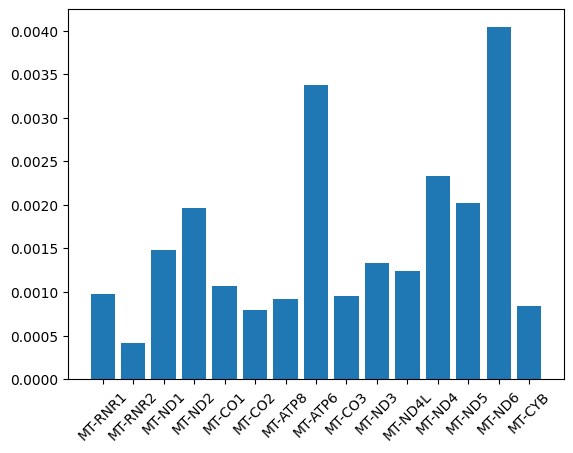

In [75]:
CV = [np.std(dataCell) / np.average(dataCell) for dataCell in np.transpose(results, (1, 2, 0))[t_current - 1]]

plt.bar(name, CV)
plt.xticks(rotation = 45)
plt.show()

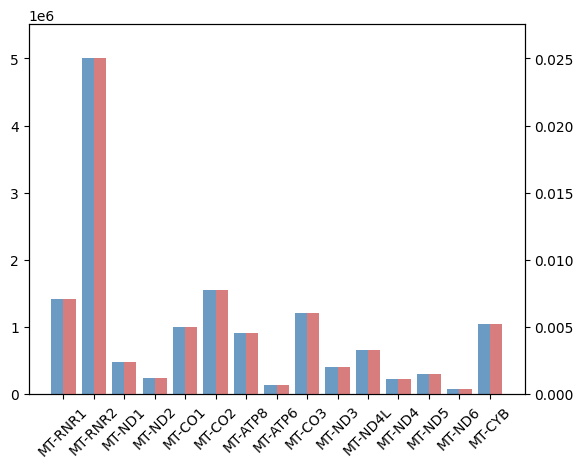

In [74]:
data = [np.average(dataCell) for dataCell in np.transpose(results, (1, 2, 0))[t_current - 1]]

fig = plt.figure()
bar_width = 0.4

ax = fig.add_subplot(111)
ax.set_ylim([0, np.max(data) * 1.1])
ax.bar(x = np.arange(len(name)), width = bar_width, height = data, label='y1', fc = 'steelblue', alpha = 0.8)

ax1 = ax.twinx()
ax1.set_ylim([0, np.max(ref) * 1.1])
ax1.bar(x = np.arange(len(name)) + bar_width, width = bar_width, height = ref, label='y1', fc = 'indianred', alpha = 0.8)

plt.xticks(np.arange(len(name)) + bar_width / 2, name) 
ax.tick_params(axis = 'x', labelrotation = 45)

plt.show()